<a href="https://colab.research.google.com/github/PaulaManoella/Estatastica-e-LLMs-CBSI/blob/main/z_score_e_binomial_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte A

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd

instalando pacote **ucimlrepo**

In [ ]:
%pip install ucimlrepo

importando def que baixa o dataset a partir do id

In [ ]:
from ucimlrepo import fetch_ucirepo

importando dataset *wine_quality* a partir de seu id

In [ ]:
wine_quality = fetch_ucirepo(id=186)

### Análise Exploratória dos Dados

Nas células abaixo executarei alguns comandos para explorar melhor o dataset utilizado.

Imprimindo número de linhas e colunas do dataset, respectivamente

In [ ]:
wine_quality.data.original.shape

(6497, 13)

Imprimindo as 5 primeiras linhas do dataset

In [ ]:
wine_quality.data.original.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Imprimindo colunas do dataset

In [ ]:
wine_quality.data.original.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color'],
      dtype='object')

A feature 'color' tem os valores 'red' e 'white', que representam, respectivamente, vinho tinto e branco. Para esta análise, selecionaremos somente os vinhos tintos (red).

Imprimindo classes do dataset

In [ ]:
sorted(wine_quality.data.original['quality'].unique())

[np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)]

Podemos ver que os valores das classes vão de 3 à 9, que indicam a qualidade do vinho.

### Definições

Na análise exploratória vimos que o dataset possue várias classes. Para tornar a análise mais simples, criaremos uma linha de corte e transformaremos em uma classe binária, onde:

* 0 = valores de 3 à 6, representam vinho ruim/comum
* 1 = valores de 7 à 9, representam vinho bom

Criando classificação binária

In [ ]:
# criando cópia do dataset
dataset_copy = wine_quality.data.original.copy()

# criando coluna com classificação binária
dataset_copy['quality_binary'] = (dataset_copy['quality'] >= 7).astype(int)

# imprimindo contagem dos valores da coluna 'quality_binary'
dataset_copy['quality_binary'].value_counts()

,count
quality_binary,
0,5220
1,1277


Com a impressão da contagem dos valores, pode-se ver que temos mais vinhos classificados como **ruim/comum (5220)** do que vinhos **bons (1227)**

In [ ]:
dataset = dataset_copy

Filtrando dataset somente com os vinhos brancos (white)

In [ ]:
dataset = dataset[dataset['color']=='white']
dataset.shape

(4898, 14)

definindo *features* e classe que serão analisadas

In [ ]:
features = ['alcohol', 'volatile_acidity']
classes = [0,1]
labels = ['0: comum', '1: premium']
map_labels = dict(zip(classes, labels))

### Plotando histogramas

Definindo função para plotar o histograma

In [ ]:
def plot_histogram(df, features, target, n_bins, plot_title, labels_map=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Distribuição por Qualidade - {plot_title}', fontsize=16)

    # 1. Preparação dos Labels para a Legenda
    # Se passarmos um mapa (ex: {0: 'comum', 1: 'premium'}), aplicamos aqui
    plot_df = df.copy()
    if labels_map:
        plot_df[target] = plot_df[target].map(labels_map)
        # Ordena a legenda com base nos valores (textos)
        sorted_labels = sorted(labels_map.values())
    else:
        sorted_labels = sorted(df[target].unique())

    for i, feature in enumerate(features):
        sns.histplot(
            data=plot_df,    # Usamos o dataframe com os textos mapeados
            x=feature,
            hue=target,
            hue_order=sorted_labels,
            element='step',
            stat='density',
            common_norm=False,
            bins=n_bins,
            # Sugestão: 'tab10' ou cores manuais são melhores para binário que 'turbo'
            palette='tab10',
            alpha=0.3,
            ax=axes[i]
        )
        axes[i].set_title(f'Feature: {feature}')
        axes[i].set_ylabel('Densidade')

    plt.tight_layout()
    plt.show()

Chamando função plot_histogram e plotando gráficos para dois tamanhos de bins diferentes

Plot 1 - 15 bins

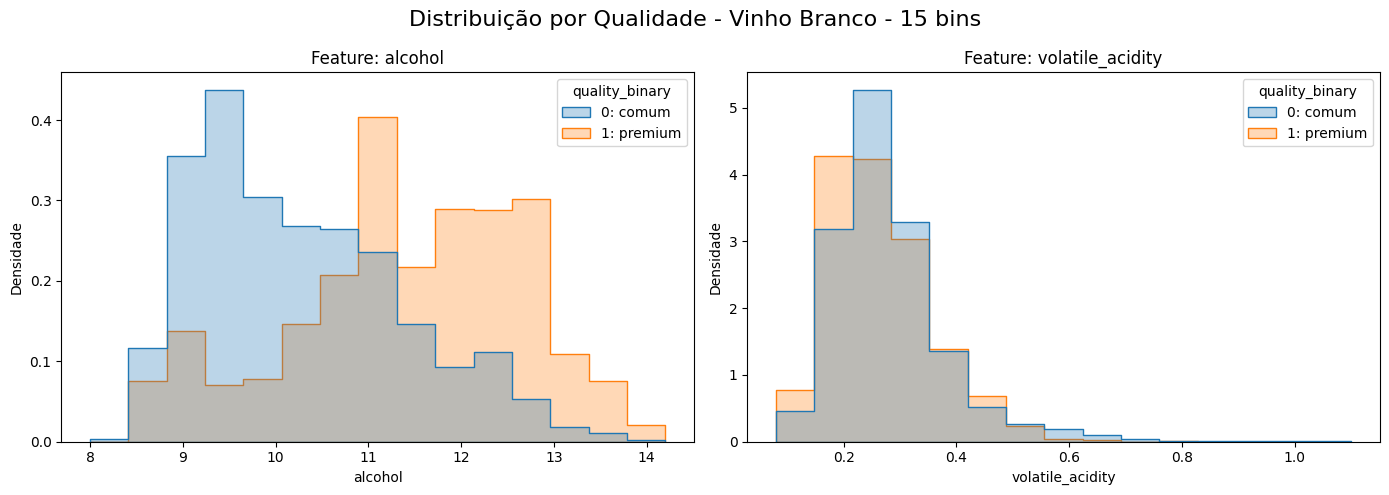

In [ ]:
plot_histogram(
    df=dataset,
    features=features,
    target='quality_binary',
    n_bins=15,
    plot_title='Vinho Branco - 15 bins',
    labels_map=map_labels
)

Figura 1

Plot 2 - 40 bins

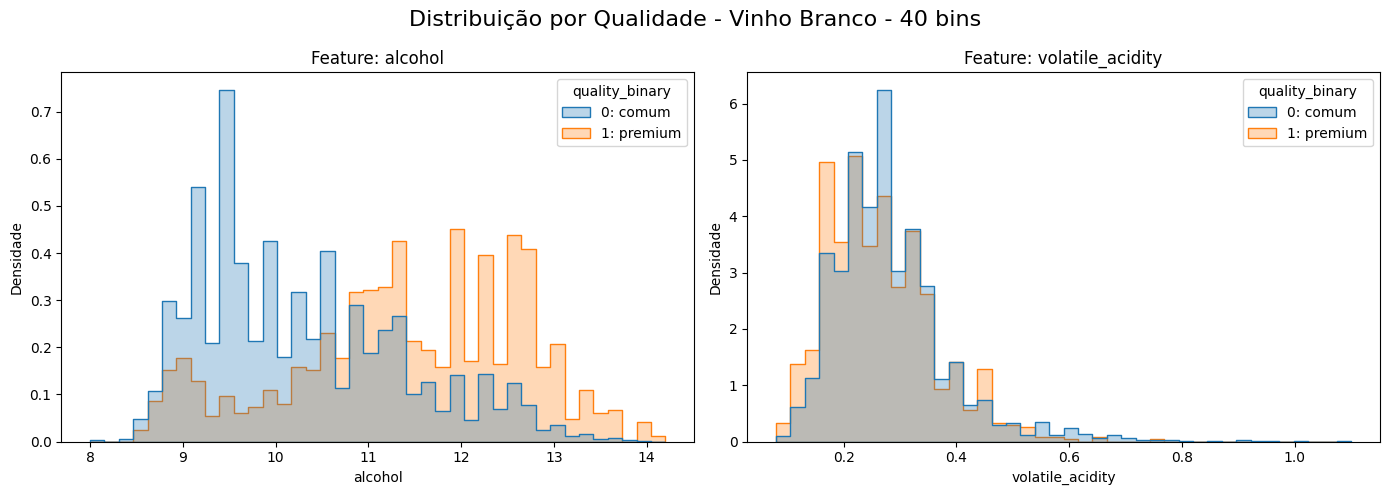

In [ ]:
plot_histogram(
    df=dataset,
    features=features,
    target='quality_binary',
    n_bins=40,
    plot_title='Vinho Branco - 40 bins',
    labels_map=map_labels
)

### Plotando histogramas com distribuição normal

Definindo função para o plot

In [ ]:
def plot_hist_normal_fit(df, features, target, labels_map=None):

    # Preparação: Mapear os nomes das classes (0 -> "Comum", 1 -> "Premium")
    plot_df = df.copy()
    if labels_map:
        plot_df[target] = plot_df[target].map(labels_map)
        # Garante que a ordem seja a definida pelos valores do mapa
        classes = sorted(labels_map.values())
    else:
        classes = sorted(plot_df[target].unique())

    # Cores fixas: Vermelho para a primeira classe (Comum), Azul para a segunda (Premium)
    # Se tiver mais classes, ele repete as cores
    colors = ['#d7191c', '#2c7bb6', 'green', 'orange']

    for feature in features:
        plt.figure(figsize=(12, 6))
        plt.title(f'Distribuição Normal Ajustada: {feature}')

        # Loop manual sobre as classes (agora com nomes descritivos)
        for i, cls in enumerate(classes):
            # Seleciona dados apenas daquela classe
            subset = plot_df[plot_df[target] == cls][feature]

            # Pula classes vazias ou com apenas 1 elemento
            if len(subset) < 2: continue

            # Escolhe a cor com segurança
            color = colors[i % len(colors)]

            # A. Plota o Histograma (Barras)
            plt.hist(subset, bins=30, density=True, alpha=0.3, color=color, label=f'Hist {cls}')

            # --- CÁLCULO DA CURVA NORMAL ---

            # B. Ajusta a Normal (Descobre a Média e Desvio Padrão)
            mu, std = norm.fit(subset)

            # C. Gera os pontos X para desenhar a linha suave
            # Dica: Usamos min/max do subset para a linha não ficar "infinita" ou cortada
            x = np.linspace(subset.min(), subset.max(), 100)

            # D. Calcula a probabilidade (PDF)
            p = norm.pdf(x, mu, std)

            # E. Plota a linha (Com correção rf'' para LaTeX)
            plt.plot(x, p, linewidth=3, color=color, label=rf'Fit {cls} ($\mu$={mu:.1f})')

            # -------------------------------

        plt.xlabel(feature)
        plt.ylabel('Densidade')
        # Posiciona a legenda para não cobrir o gráfico
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

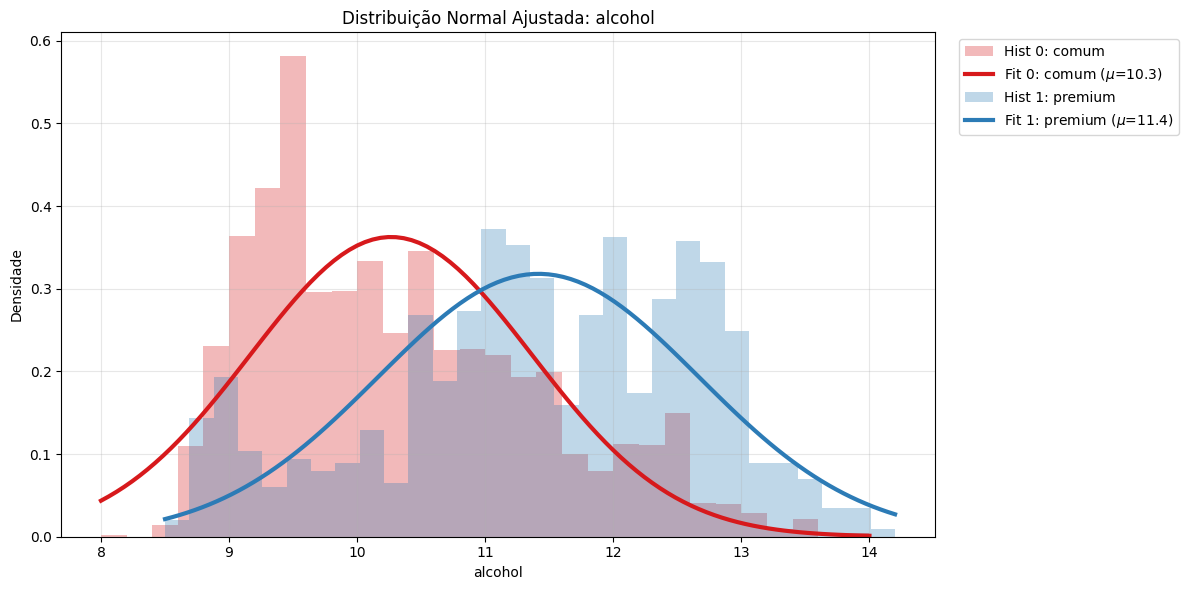

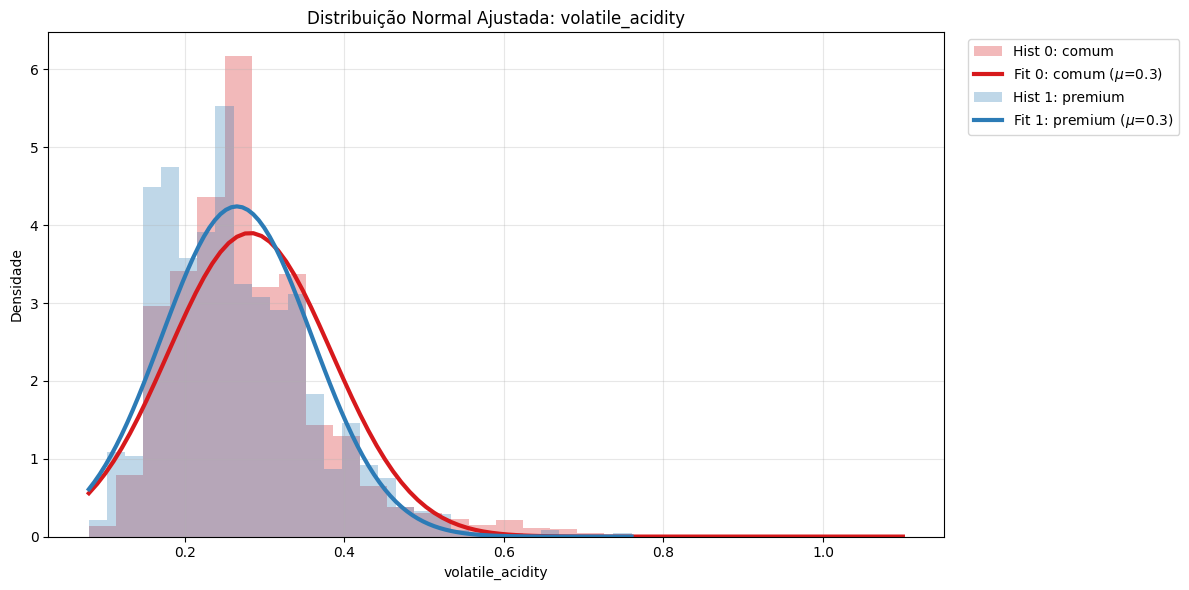

In [ ]:
plot_hist_normal_fit(
    df=dataset,
    features=features,
    target='quality_binary',
    labels_map=map_labels
)

Figura 4

# Parte B

**Contextualização:**

Com base nos histogramas plotados, foi possível identificar que o teor alcoólico (feature alcohol) é um forte discriminante para determiar a qualidade do vinho, isso pq na figura 3 é possível notar a classe 1 com uma distribuição mais deslocada para a direita (média 11.5).

**Experimento:**

Assumindo o papel de garantir a qualidade dos vinhos produzidos, o objetivo é garantir que a produção de vinhos mantenha um padrão elevado. Dessa forma, calcularemos a probabilidade de um vinho premium (classe 1) ter **menos de 10% de álcool** (característica que o aproximaria da classe de vinho comum).

**Parâmetros coletados:**

*   Média de vinhos premium
*   Desvio padrão de vinhos premium



Filtrando população de interesse (vinho branco premium)

In [ ]:
premium_white_wine = dataset[dataset['quality_binary']==1]['alcohol']
premium_white_wine

,alcohol
1612,12.40
1614,11.40
1616,12.80
1619,12.80
1620,11.00
...,...
6469,11.45
6475,11.60
6485,12.15
6486,13.00


Temos um total de 1060 vinhos brancos premium

Obtendo média e desvio padrão reais da população de interesse

In [ ]:
# média
real_mean = premium_white_wine.mean()

# desvio padrão
real_std = premium_white_wine.std()

# imprimindo estatísticas
print(f'Média dados reais: {real_mean:.2f}\nDesvio padrão dados reais: {real_std:.2f}\nTotal de amostras utilizadas no cálculo: {len(premium_white_wine)}')

Média dados reais: 11.42
Desvio padrão dados reais: 1.26
Total de amostras utilizadas no cálculo: 1060


### Simulando dados para o experimento

In [ ]:
np.random.seed(10)

# número de amostras
n_samples = 1000

simulated_data = np.random.normal(loc=real_mean,
                                  scale=real_std,
                                  size=n_samples)

### Plotando histograma para os dados simulados

Transformando simulated_data em um DataFrame para ser compatível com a entrada da função **plot_hist_normal_fit**

In [ ]:
df_simulated_data = pd.DataFrame({
    'alcohol': simulated_data,
    'class': 'simulated'
})

Chamando função e plotando histograma

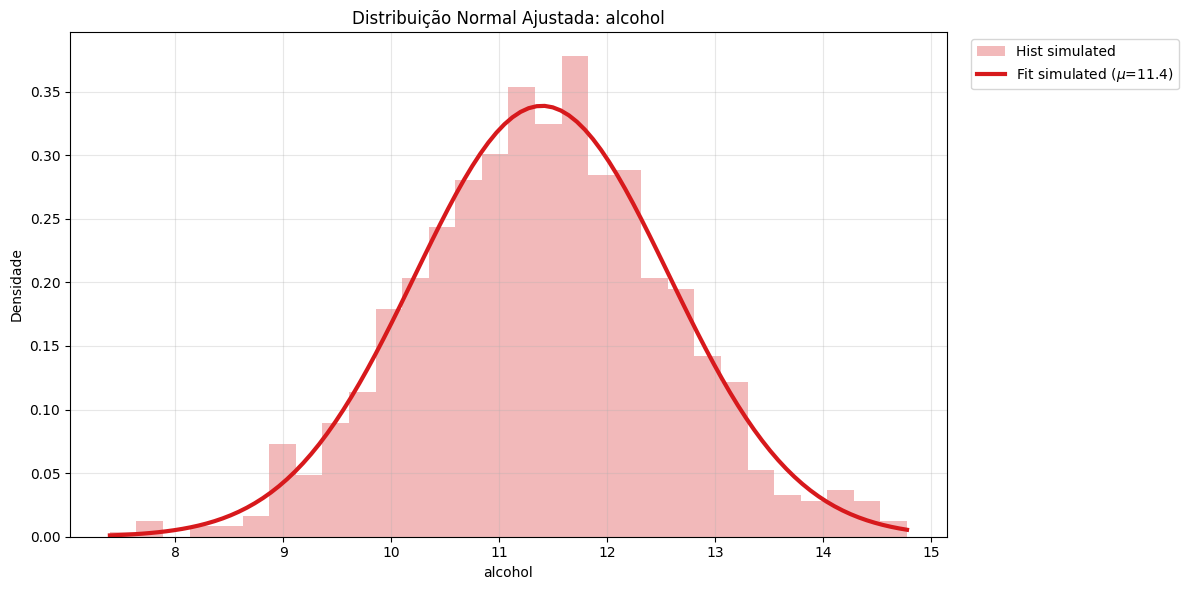

In [ ]:
plot_hist_normal_fit(df=df_simulated_data,
                     features=['alcohol'],
                      target='class')

### Gerando tabela de probabilidades

In [ ]:
print(f"Parâmetros da Simulação: Média={real_mean:.2f}, Sigma={real_std:.2f}")

# 2. Função para Gerar a Tabela (Igual fizemos antes)
def gerar_tabela_final(mu, sigma):
    # Cenários ajustados para Vinho Branco Premium (Média 11.4)
    cenarios = [
        # Cenário A: Vinho "Fraco" (Risco de Qualidade - Abaixo de 10.5%)
        {"desc": "Álcool < 10.5%", "tipo": "menor", "val1": 10.5, "val2": None},

        # Cenário B: Vinho "Forte" (Acima de 13.5%)
        {"desc": "Álcool > 13.5%", "tipo": "maior", "val1": 13.5, "val2": None},

        # Cenário C: Faixa Padrão (Entre 11% e 12%)
        {"desc": "Entre 11.0% e 12.0%", "tipo": "entre", "val1": 11.0, "val2": 12.0}
    ]

    lista_resultados = []

    for item in cenarios:
        val1, val2 = item["val1"], item["val2"]

        # A. CÁLCULO NÃO PADRONIZADO (Direto com os valores reais)
        if item["tipo"] == "menor":
            prob_raw = norm.cdf(val1, loc=mu, scale=sigma)
        elif item["tipo"] == "maior":
            prob_raw = 1 - norm.cdf(val1, loc=mu, scale=sigma)
        elif item["tipo"] == "entre":
            prob_raw = norm.cdf(val2, loc=mu, scale=sigma) - norm.cdf(val1, loc=mu, scale=sigma)

        # B. CÁLCULO PADRONIZADO (Z-Score)
        # Z = (Val - Média) / Desvio
        z1 = (val1 - mu) / sigma
        z2 = (val2 - mu) / sigma if val2 else 0

        if item["tipo"] == "menor":
            prob_std = norm.cdf(z1)
            str_z = f"Z < {z1:.2f}"
        elif item["tipo"] == "maior":
            prob_std = 1 - norm.cdf(z1)
            str_z = f"Z > {z1:.2f}"
        elif item["tipo"] == "entre":
            prob_std = norm.cdf(z2) - norm.cdf(z1)
            str_z = f"{z1:.2f} < Z < {z2:.2f}"

        lista_resultados.append({
            "Cenário": item["desc"],
            "Prob. (Real)": f"{prob_raw:.4f}",
            "Cálculo Z": str_z,
            "Prob. (Padronizada)": f"{prob_std:.4f}"
        })

    return pd.DataFrame(lista_resultados)

# 3. Exibir Tabela
tabela = gerar_tabela_final(real_mean, real_std)
tabela
# print("\n--- TABELA DE PROBABILIDADES (SIMULAÇÃO VINHO BRANCO) ---")
# print(tabela.to_markdown(index=False))

Parâmetros da Simulação: Média=11.42, Sigma=1.26


,Cenário,Prob. (Real),Cálculo Z,Prob. (Padronizada)
0,Álcool < 10.5%,0.2328,Z < -0.73,0.2328
1,Álcool > 13.5%,0.0484,Z > 1.66,0.0484
2,Entre 11.0% e 12.0%,0.3090,-0.33 < Z < 0.47,0.3090
